**Tying Weights**

In [6]:
import tensorflow as tf
import numpy as np

In [3]:
# custom layer
class DenseTranspose(tf.keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    super().__init__(**kwargs)
    self.dense = dense
    self.activation = tf.keras.activations.get(activation)

  def build(self, batch_input_shape):
    self.biases = self.add_weight(
        name='bias',
        shape=[self.dense.input_shape[-1]],
        initializer='zeros'
     )

  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True) + self.biases
    return self.activation(z)

In [5]:
dense_1 = tf.keras.layers.Dense(100, activation='relu')
dense_2 = tf.keras.layers.Dense(30, activation='relu')

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([-1, 28, 28])
])

tied_autoencoder = tf.keras.Sequential([
    tied_encoder,
    tied_decoder
])

In [24]:
# loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [8]:
tf.random.set_seed(42)

tied_autoencoder.compile(loss="mse", optimizer="nadam")
history = tied_autoencoder.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 11s 4ms/step - loss: 0.0891 - val_loss: 0.0878
Epoch 2/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0871 - val_loss: 0.0877
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0871 - val_loss: 0.0878
Epoch 4/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0871 - val_loss: 0.0880
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0871 - val_loss: 0.0877
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0871 - val_loss: 0.0878
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0871 - val_loss: 0.0876
Epoch 8/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0871 - val_loss: 0.0877
Epoch 9/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0872 - val_loss: 0.0877
Epoch 10/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.08

**Convolutional Autoencoders**

In [15]:
tf.random.set_seed(42)

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(30, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D() # ouput 30
])

conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3*3*16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])

conv_autoencoder = tf.keras.Sequential([
    conv_encoder,
    conv_decoder
])

conv_autoencoder.compile(loss="mse", optimizer="nadam")
history = conv_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 19s 8ms/step - loss: 0.0287 - val_loss: 0.0199
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0184 - val_loss: 0.0173
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0146 - val_loss: 0.0143
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0135 - val_loss: 0.0137
Epoch 8/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 9/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 10/10
1719/1719 [==============================] - 12s 7ms/step - l

In [27]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 [==============================] - 0s 20ms/step


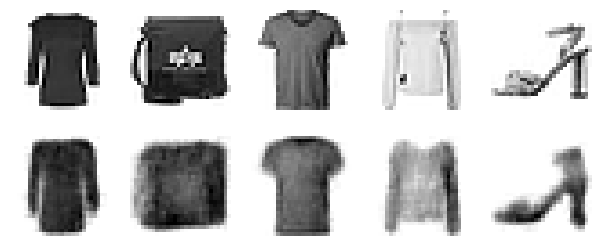

In [21]:
plot_reconstructions(conv_autoencoder)
plt.show()

**Recurrent Autoencoders**

In [29]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_autoencoder = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_autoencoder.compile(loss="mse", optimizer="nadam")

history = recurrent_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 31s 13ms/step - loss: 0.0265 - val_loss: 0.0196
Epoch 2/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 3/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0155 - val_loss: 0.0154
Epoch 4/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0142 - val_loss: 0.0134
Epoch 5/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 6/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0125 - val_loss: 0.0121
Epoch 7/10
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0120 - val_loss: 0.0117
Epoch 8/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 9/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 10/10
1719/1719 [==============================] - 19s 11m

1/1 [==============================] - 1s 940ms/step


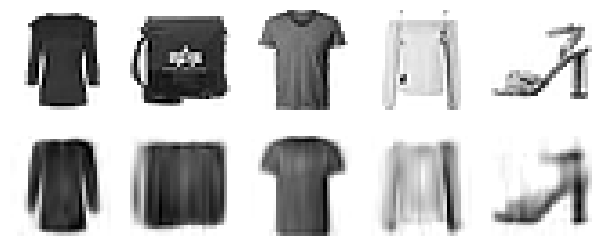

In [30]:
plot_reconstructions(recurrent_autoencoder)
plt.show()

**Denoising Autoencoders Using Dropout**

In [31]:
tf.random.set_seed(42)

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), # noise
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_autoencoder = tf.keras.Sequential([dropout_encoder, dropout_decoder])


dropout_autoencoder.compile(loss="mse", optimizer="nadam")
history = dropout_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 5ms/step - loss: 0.0290 - val_loss: 0.0220
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0226 - val_loss: 0.0204
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0216 - val_loss: 0.0198
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0210 - val_loss: 0.0194
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0206 - val_loss: 0.0190
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0203 - val_loss: 0.0189
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0200 - val_loss: 0.0186
Epoch 8/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0197 - val_loss: 0.0182
Epoch 9/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0195 - val_loss: 0.0181
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0

1/1 [==============================] - 0s 70ms/step


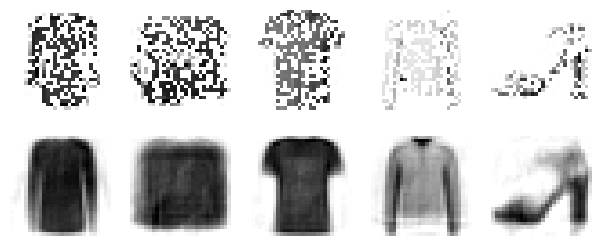

In [32]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_autoencoder, dropout(X_valid, training=True))
plt.show()

**Sparse Autoencoder**

In [33]:
tf.random.set_seed(42)

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_autoencoder = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_autoencoder.compile(loss="mse", optimizer="nadam")
history = sparse_l1_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 5ms/step - loss: 0.0276 - val_loss: 0.0194
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0173 - val_loss: 0.0158
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0150 - val_loss: 0.0143
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0137 - val_loss: 0.0134
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0120 - val_loss: 0.0120
Epoch 8/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 9/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0114 - val_loss: 0.0116
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.01

1/1 [==============================] - 0s 76ms/step


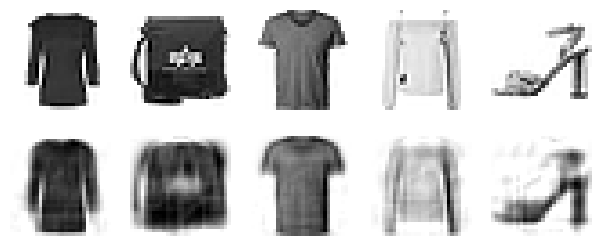

In [34]:
plot_reconstructions(sparse_l1_autoencoder)
plt.show()

**Sparse Autoencoder Using KL-divergence Reguralizer**

In [35]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities)
            )

In [36]:
tf.random.set_seed(42)

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)

sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_autoencoder = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

sparse_kl_autoencoder.compile(loss="mse", optimizer="nadam")
history = sparse_kl_autoencoder.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 13s 5ms/step - loss: 0.0252 - val_loss: 0.0170
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0149 - val_loss: 0.0138
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 8/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0097 - val_loss: 0.0103
Epoch 9/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 10/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.

1/1 [==============================] - 0s 90ms/step


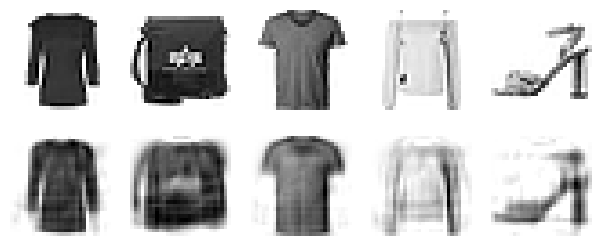

In [37]:
plot_reconstructions(sparse_kl_autoencoder)
plt.show()

**Variational Autoencoder**

In [38]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [43]:
# building the model using functional API as the model is not fully sequential
tf.random.set_seed(42)

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])

Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)

codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ

codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [44]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])

x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)

outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [45]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_autoencoder = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [46]:
latent_loss = -0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1)
variational_autoencoder.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [47]:
variational_autoencoder.compile(loss="mse", optimizer="nadam")
history = variational_autoencoder.fit(X_train, X_train, epochs=10, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/10
430/430 [==============================] - 8s 9ms/step - loss: 0.0498 - val_loss: 0.0385
Epoch 2/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0363 - val_loss: 0.0358
Epoch 3/10
430/430 [==============================] - 4s 9ms/step - loss: 0.0346 - val_loss: 0.0345
Epoch 4/10
430/430 [==============================] - 3s 8ms/step - loss: 0.0338 - val_loss: 0.0336
Epoch 5/10
430/430 [==============================] - 5s 12ms/step - loss: 0.0331 - val_loss: 0.0331
Epoch 6/10
430/430 [==============================] - 3s 7ms/step - loss: 0.0327 - val_loss: 0.0328
Epoch 7/10
430/430 [==============================] - 3s 6ms/step - loss: 0.0324 - val_loss: 0.0327
Epoch 8/10
430/430 [==============================] - 3s 7ms/step - loss: 0.0322 - val_loss: 0.0324
Epoch 9/10
430/430 [==============================] - 3s 7ms/step - loss: 0.0321 - val_loss: 0.0324
Epoch 10/10
430/430 [==============================] - 3s 8ms/step - loss: 0.0319 - val_loss: 0.032

1/1 [==============================] - 0s 118ms/step


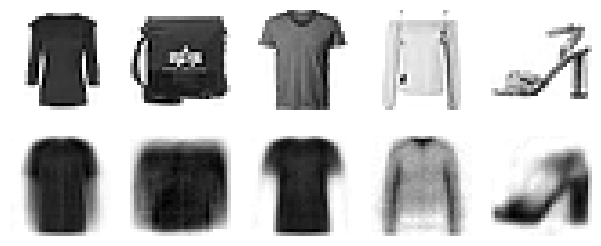

In [48]:
plot_reconstructions(variational_autoencoder)
plt.show()

**Generate Fashion Images**

In [49]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

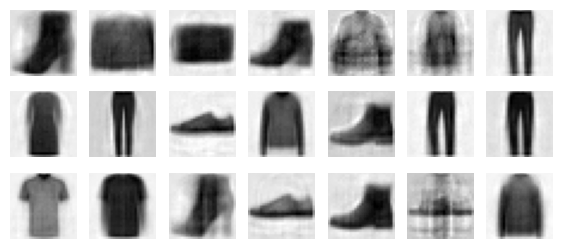

In [50]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
plt.show()

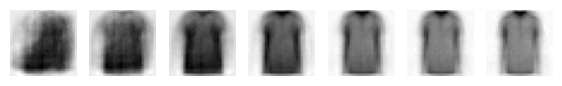

In [51]:
tf.random.set_seed(42)

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)
images = variational_decoder(codings).numpy()

plot_multiple_images(images)
plt.show()